## AOPP weather station data

download data from https://weatherstationdata.physics.ox.ac.uk

excerpt from weatherstationdata readme:

The data is stored as text files, sorted into folders by year. One file is generated for each day, named MPYYYYMMDD.csv, where MP is a label, YYYY is the year, MM is the month, and DD is the day. The files consists of a series of rows, with each row corresponding to a single observation. There is no header. A row follows the format:

DD-MM-YYYY, HH:II:SS, WD, WS, TEMP, SUN, RAIN, PRE, HUM, WET
- DD =   day of month, 1-31;
- MM =   month of year, 1-12;
- YYYY = year;
- HH =   hour of day, 0-23;
- II =   minute of hour, 0-59;
- SS =   second of minute, 0-59;
- WD =   wind direction, to the nearest degree;
- WS =   wind speed, in metres per second to one decimal place;
- TEMP = dry bulb temperature, in Celsius to one decimal place;
- SUN =  the number of hours of sunshine since the last observation, in hours to two decimal places;
- RAIN = rainfall since the last observation, in millimetres to two decimal places;
- PRE =  pressure, to the nearest hectopascal;
- HUM =  relative humidty observed by a solid-state sensor, in percent;
- WET =  wet bulb temperature, in Celsius.

Missing data are indicated by the value -999.

### utils

In [ ]:
import pandas as pd
import os
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt


##############################################
# AOPP weather station data helper functions #
##############################################


def get_daily_sun_hours(filepath: str, columns: list[str]) -> float:
    """
    Function to read a daily weather station file and return the total sun hours for the day
    and the amount of sun between 3pm and 4pm.
    
    Args:
    filepath: str, the path to the daily weather station file
    columns: list, the column names of the weather station file

    Returns:
    float, the total sun hours for the day
    """
    try:   
        df = pd.read_csv(filepath, header=None, skipinitialspace=True)
        df.columns = columns
        date = datetime.strptime(df['date'][0], '%d-%m-%Y')
        sun_per_day = df['sun'].sum()
        sun_3to4pm = df[df['time'].str[:2]=='15']['sun'].sum()
        return date, sun_per_day, sun_3to4pm
    except Exception as e:
        print(f'Error reading file {filepath}: {e}')
        return np.nan
    

############################
# ML Task helper functions #
############################

def split_data(X, y, train_len, test_len, buffer_len=0):
    """
    Splits the data into training and test sets by taking 
    sequences of length train_len for training and test_len for testing 
    with a buffer of length buffer_len between each sequence.

    """
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    i = 0
    while i < len(X):
        # Add training samples
        end_train = min(i + train_len, len(X))
        X_train.extend(X[i:end_train])
        y_train.extend(y[i:end_train])

        # Move the index to the start of the test set, skipping the buffer
        i = end_train + buffer_len
        
        # Add test samples
        end_test = min(i + test_len, len(X))
        X_test.extend(X[i:end_test])
        y_test.extend(y[i:end_test])

        # Move the index to the next training set, skipping the buffer
        i = end_test + buffer_len

    # Convert to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_train, y_train, X_test, y_test

## analysis

In [58]:
year_dir = './data/2021/'
weather_station_files = os.listdir(year_dir)
weather_station_files = [f for f in weather_station_files if f.startswith('MP')]
weather_station_files.sort()

columns = [
    'date', 
    'time', 
    'wind-direction',
    'wind-speed', 
    'temperature',
    'sun',
    'rain',
    'pressure',
    'humidity',
    'wet-bulb-temperature']

In [59]:
df = pd.read_csv(year_dir + weather_station_files[0], header=None, skipinitialspace=True)
df.columns = columns
# sum sun between 3 and 4pm 
df[df['time'].str[:2]=='15']['sun'].sum()

0.0

In [60]:
daily_sun_hours = [get_daily_sun_hours(os.path.join(year_dir, file), columns) for file in weather_station_files]
# turn tuples of (date, sun hours) into a dataframe
daily_sun_df = pd.DataFrame(daily_sun_hours, columns=['date', 'sun per day', 'sun 3-4pm'])
daily_sun_df.head()

,date,sun per day,sun 3-4pm
0,2021-01-01,0.00,0.00
1,2021-01-02,3.09,0.00
2,2021-01-03,0.71,0.03
3,2021-01-04,0.02,0.00
4,2021-01-05,1.37,0.00


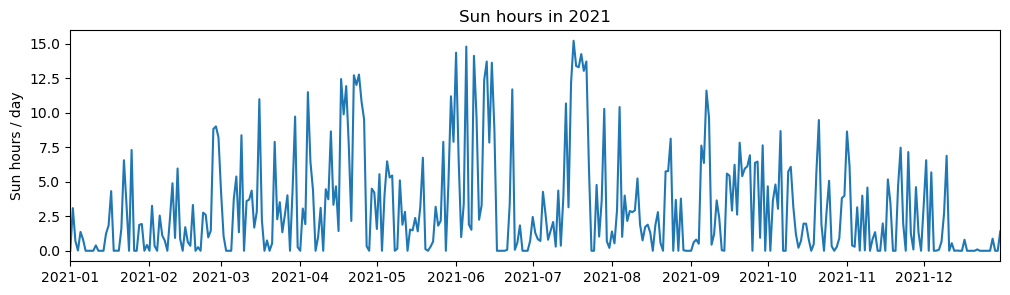

In [192]:
plt.figure(figsize=(12, 3))
# plot daily sun hours
plt.plot(daily_sun_df['date'], daily_sun_df['sun per day'])
plt.title('Sun hours in 2021')
plt.ylabel('Sun hours / day')

# convert xaxis days to months
plt.xlim(daily_sun_df['date'].min(), daily_sun_df['date'].max())

plt.show()

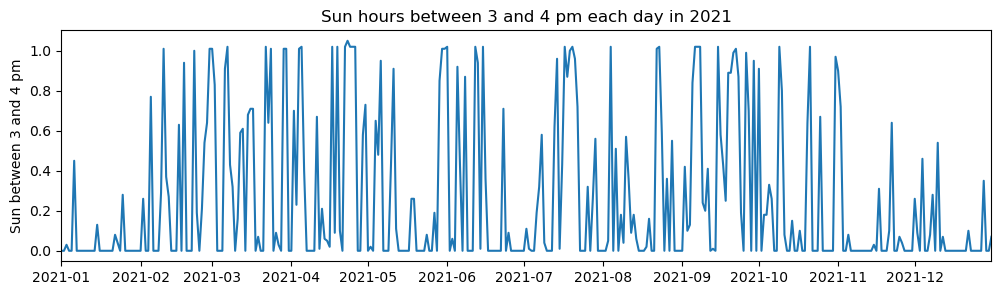

In [191]:
plt.figure(figsize=(12, 3))
# plot daily sun hours
plt.plot(daily_sun_df['date'], daily_sun_df['sun 3-4pm'])
plt.title('Sun hours between 3 and 4 pm each day in 2021')
plt.ylabel('Sun between 3 and 4 pm')

# convert xaxis days to months
plt.xlim(daily_sun_df['date'].min(), daily_sun_df['date'].max())

plt.show()

# ML task: predict daily sun hours based on previous 3 days

- could create 2 dataset splits: one uses december & november for testing, one uses the last 6 days in each month
- Q: do you think one of these options works better? if yes, why? if no, why not?
- Can we randomly choose 80% of input-output pairs for the training set and use the other 20% for testing?

### utils

In [178]:
#####################################################
# helper functions to create ML timeseries datasets #
#####################################################

def _timeseries_for_continuous_data(df: pd.DataFrame, 
                                    target_column: str,
                                    inputs_length: int = 3) -> tuple[np.ndarray, np.ndarray]:
    """
    Function to create a time series dataset from a DataFrame that contains continuous data (no temporal gaps).

    Args:
    df: DataFrame, the input data
    target_column: str, the name of the target column
    inputs_length: int, the length of the input sequences (default is 3)

    Returns:
    X: numpy array, the input sequences of length input_sequence_length
    y: numpy array, the target values for each input sequence which are the sun hours on the day after
    """
    assert inputs_length > 0, 'Input sequence length must be greater than 0'
    # Sort by date to ensure chronological order
    df = df.sort_values(by='date').reset_index(drop=True)
    
    X, y, y_date = [], [], []
    
    # Loop through the DataFrame and create sequences
    for i in range(inputs_length, len(df)):
        # Input: previous input_length days
        X.append(df[target_column].iloc[i-inputs_length:i].values)
        
        # Output: sun measurement on the day after
        y.append(df[target_column].iloc[i])

        # Date of the target value
        y_date.append(df['date'].iloc[i])
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    return X, y, y_date


def create_timeseries_dataset(df: pd.DataFrame, 
                              target_column: str = 'sun per day',
                              inputs_length: int = 3) -> tuple[np.ndarray, np.ndarray]:
    """
    Function to create a time series dataset from a DataFrame.
    
    Args:
    df: DataFrame, the input data
    target_column: str, the name of the target column

    Returns:
    X: numpy array, the input sequences of length input_sequence_length
    y: numpy array, the target values for each input sequence which are the sun hours on the day after
    """
    X, y, y_dates = [], [], []
    
    # Ensure 'date' is datetime and sort by date
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date').reset_index(drop=True)
    
    # Group by year and month to avoid sequences spanning multiple months
    for _, monthly_df in df.groupby([df['date'].dt.year, df['date'].dt.month]):
        # Generate sequences within each month
        X_month, y_month, y_dates_month = _timeseries_for_continuous_data(monthly_df, target_column=target_column, inputs_length=inputs_length)
        
        # Append results to the overall dataset
        X.extend(X_month)
        y.extend(y_month)
        y_dates.extend(y_dates_month)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    y_dates = np.array(y_dates)
    
    return X, y, y_dates

def get_test_train_split_df(df: pd.DataFrame, day_split: int = 23) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits a DataFrame into training and test sets based on a day of the month.

    Args:
    df: pd.DataFrame, the DataFrame to split
    day_split: int, the day of the month to split on (default is 23 which results in 82% training set, 18% test set)

    Returns:
    tuple, training set and test set DataFrames (df_train, df_test)
    """
    df['date'] = pd.to_datetime(df['date'])
    df['day'] = df['date'].dt.day
    df_train = df[df['day'] <= day_split].copy().drop(columns=['day'])
    df_test = df[df['day'] > day_split].copy().drop(columns=['day'])
    return df_train, df_test


####################################################
# Helper functions to plot time series predictions #
####################################################

def plot_time_series_predictions(
        y_true, 
        y_dates, 
        y_pred_train,
        y_pred_test, 
        y_dates_train, 
        y_dates_test,
        xlim=(pd.Timestamp('2021-01-01'), pd.Timestamp('2021-03-01'))
    ):
    plt.figure(figsize=(12, 3))
    plt.plot(y_dates,
            y_true,
            '-x',
            label='Measurements',
            linewidth=1,
            markersize=4,
            markeredgewidth=1.5,)

    plt.plot(y_dates_train, y_pred_train, '*', label='Predicted (train)')
    plt.plot(y_dates_test, y_pred_test, '*', label='Predicted (test)')
    plt.xlim(xlim)
    plt.legend()

## Random Forest Regression

In [114]:
# split the data into training and test sets
df_train, df_test = get_test_train_split_df(daily_sun_df)

# create input and output matrices for the training and test timeseries datasets
X_train, y_train, y_dates_train = create_timeseries_dataset(df_train, target_column='sun per day', inputs_length=3)
X_test, y_test, y_dates_test = create_timeseries_dataset(df_test, target_column='sun per day', inputs_length=3)

In [177]:
# train a random forest regressor on the training data
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# create and train the model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# calculate the mean squared error
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f'Training MSE: {mse_train:.2f}')
print(f'Test MSE: {mse_test:.2f}')

Training MSE: 1.72
Test MSE: 11.89


In [187]:
# train a random forest regressor on the training data
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# create and train the model
model = RandomForestRegressor(max_depth=3)
model.fit(X_train, y_train)

# make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# calculate the mean squared error
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f'Training MSE: {mse_train:.2f}')
print(f'Test MSE: {mse_test:.2f}')

Training MSE: 8.14
Test MSE: 9.81


### Q*: RandomForest hyperparameters

The Random Forest seems to be heavily overfitting to the input dataset (how do we know this?). We don't expect great model performance, but this seems quite severe. Read the documentation of the [RandomForestRegressor](https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestRegressor.html) and choose 2 hyperparameters which can improve this issue. test a few parameter combinations (e.g., change a parameter that defaults to 1 to 2, 5, ...). How does this affect model performance?

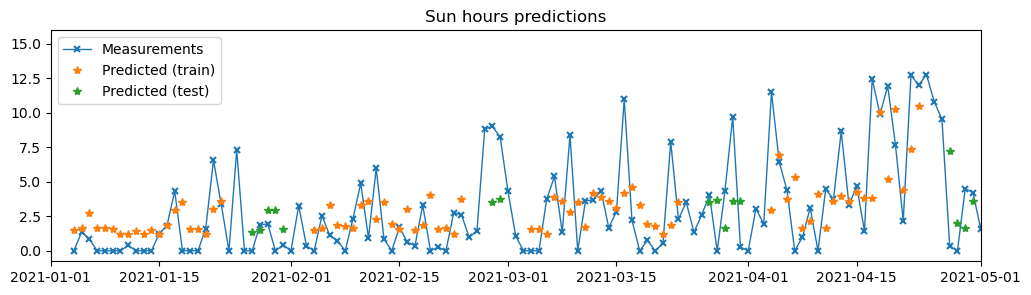

In [188]:
plot_time_series_predictions(
    y_true=daily_sun_df['sun per day'][3:],
    y_dates=daily_sun_df['date'][3:],
    y_pred_train=y_pred_train,
    y_pred_test=y_pred_test,
    y_dates_train=y_dates_train,
    y_dates_test=y_dates_test,
    xlim=(pd.Timestamp('2021-01-01'), pd.Timestamp('2021-05-01'))
)

plt.title('Sun hours predictions')
plt.show()

## CNN + Earth Observation Data

In [193]:
# input: 9am satellite image
# output: predicted sun hours for the day

## Adding environmental inputs

In [194]:
# input image + wind
# 3 day sun hours + temperature + wind
# study feature importance